In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

# print("sys.path", sys.path)

import matplotlib
import matplotlib.pyplot as plt

# import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
# import vision_pipeline.obb
# import imagesize
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
# from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
# from shapely.geometry import Polygon
from rich import print
# from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera, detections_to_ros, detections_to_py
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle

from context_action_framework.srv import VisionDetection, VisionDetectionResponse, VisionDetectionRequest, ProcessImg, ProcessImgResponse

from action_predictor.graph_relations import GraphRelations

from cv_bridge import CvBridge
import rospy


rospy.init_node("test_node")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
img_path = os.path.expanduser("~/datasets2/reconcycle/2023-08-01_basler_hca_backs/0001.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_01/00_template_0039.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_03.1/0182.jpg")


img = cv2.imread(img_path)
img = imutils.resize(img, width=1450, height=1450)

# display(PILImage.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

In [4]:
def call_process_img(img):
    timeout = 3 # 2 second timeout
    rospy.wait_for_service('vision/basler/process_img', timeout)

    imgmsg = CvBridge().cv2_to_imgmsg(img, encoding="bgr8")
    try:
        process_img = rospy.ServiceProxy('vision/basler/process_img', ProcessImg)
        response = process_img(imgmsg)
        detections = detections_to_py(response.detections)
        labelled_img = CvBridge().imgmsg_to_cv2(response.labelled_image, desired_encoding='passthrough')
        
        return response.success, detections, labelled_img
        # return response
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)



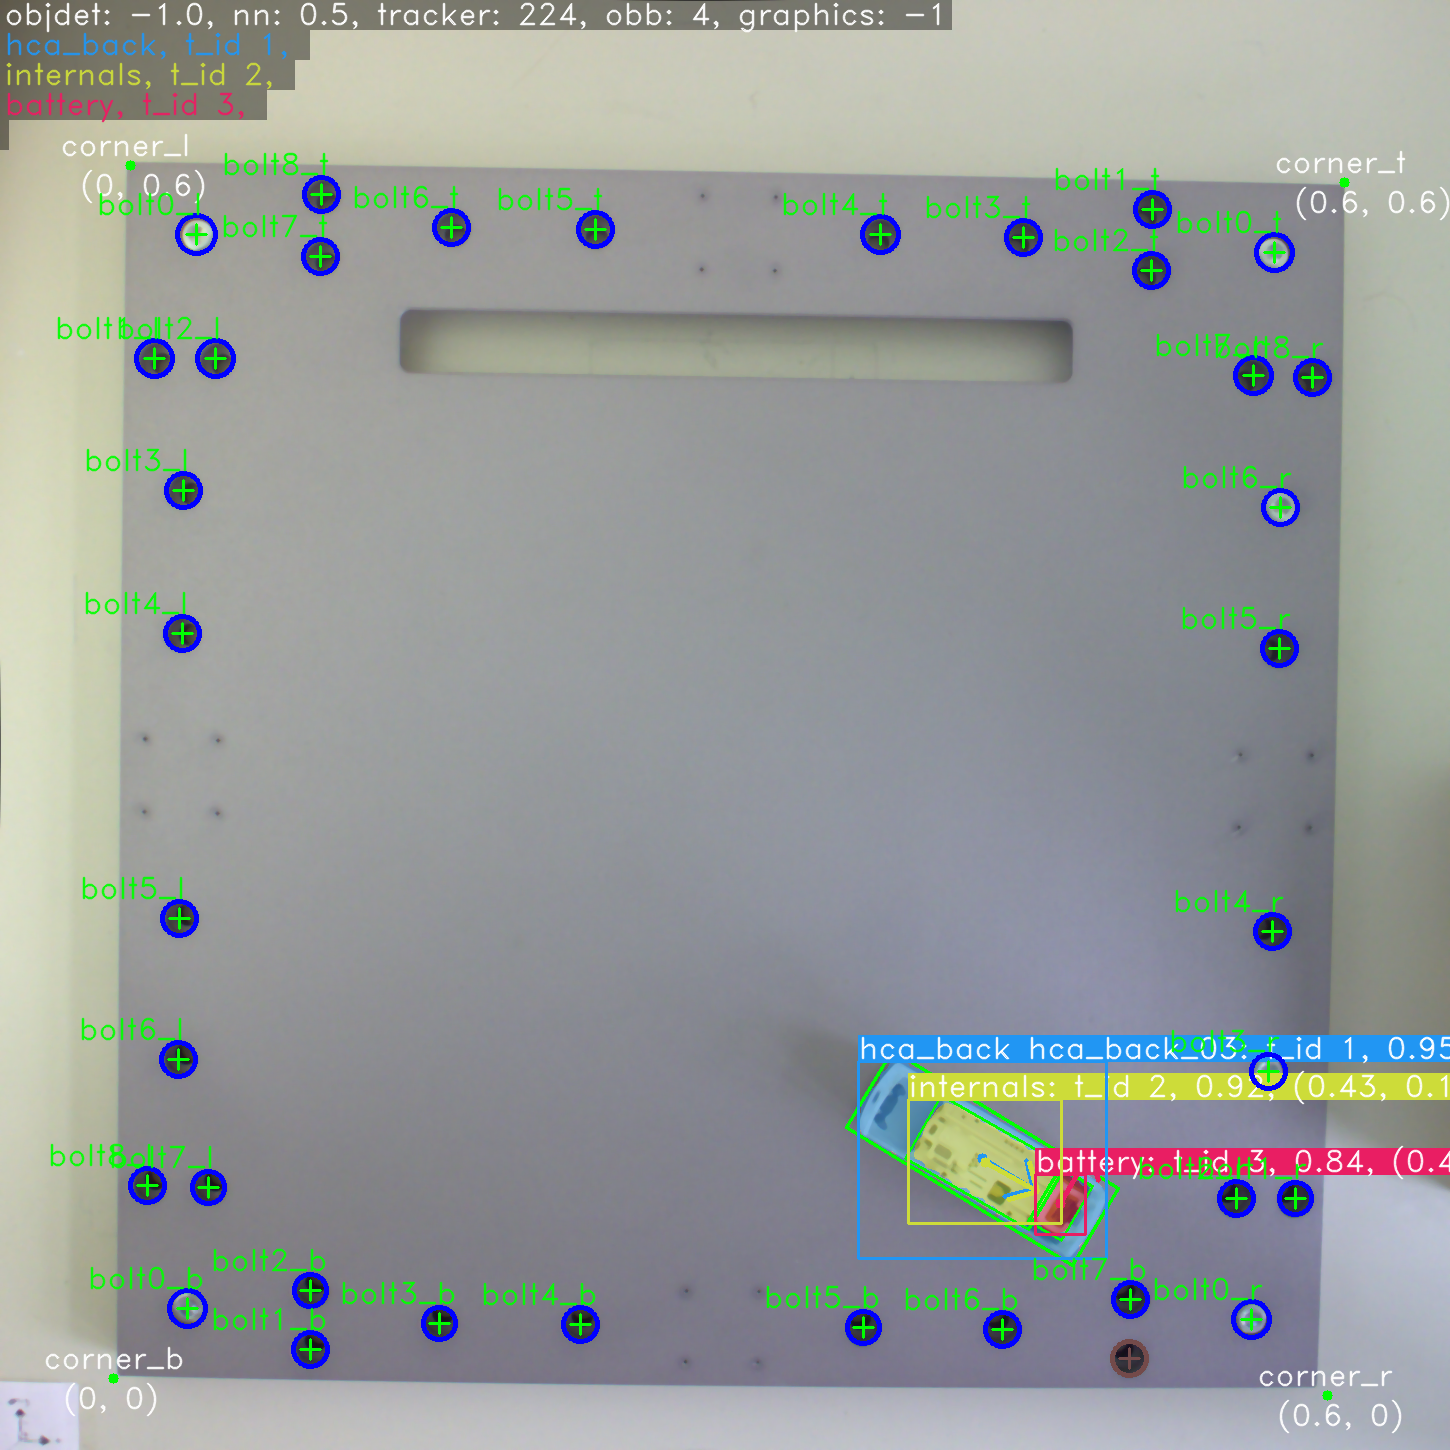

detections
[
    Detection(
        id=0,
        tracking_id=1,
        label=<Label.hca_back: 1>,
        label_precise='hca_back_03',
        score=0.9498966932296753,
        tf_px=translation: 
  x: 982.0
  y: 1158.0
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: -0.2703736508476598
  w: 0.9627554668384427,
        box_px=array([[ 858.92407227, 1061.92199707],
       [1106.22351074, 1258.76635742]]),
        obb_px=array([[ 846., 1127.],
       [ 892., 1050.],
       [1118., 1188.],
       [1072., 1265.]]),
        center_px=array([ 982., 1158.]),
        polygon_px=<POLYGON ((905 1062, 921 1070, 1029 1134, 1073 1161, 1083 1169, 1094 1179, 1...>,
        tf=translation: 
  x: 0.42794015689463083
  y: 0.11483161593590618
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: -0.2703736508476598
  w: 0.9627554668384427,
        box=array([[0.36643121, 0.16150551],
       [0.49004969, 0.06584704]]),
        obb=array([[0.36050829, 0.12923476],
       [0.38269219, 0.16762669],
       [0.4953649 , 0.10092299],
       [0.47318098, 0.06253106]]),
        center=array([0.42794016, 0.11483162, 0.        ]),
        polygon=<POLYGON Z ((0.389 0.162 0.025, 0.397 0.158 0.025, 0.451 0.127 0.025, 0.473 ...>,
        obb_3d=array([[0.36050829, 0.12923476, 0.        ],
       [0.38269219, 0.16762669, 0.        ],
       [0.4953649 , 0.10092299, 0.        ],
       [0.47318098, 0.06253106, 0.        ],
       [0.36050829, 0.12923476, 0.025     ],
       [0.38269219, 0.16762669, 0.025     ],
       [0.4953649 , 0.10092299, 0.025     ],
       [0.47318098, 0.06253106, 0.025     ]]),
        mask=None,
        mask_contour=None,
        tracking_score=None,
        tracking_box=None
    ),
    Detection(
        id=1,
        tracking_id=2,
        label=<Label.internals: 6>,
        label_precise='',
        score=0.922561764717102,
        tf_px=translation: 
  x: 985.0
  y: 1162.0
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: -0.2566679299220842
  w: 0.9664996501548835,
        box_px=array([[ 908.7322998 , 1099.98913574],
       [1061.61572266, 1223.85461426]]),
        obb_px=array([[ 905., 1158.],
       [ 941., 1095.],
       [1065., 1166.],
       [1028., 1229.]]),
        center_px=array([ 985., 1162.]),
        polygon_px=<POLYGON ((946 1100, 936 1110, 936 1111, 934 1113, 934 1114, 932 1116, 932 1...>,
        tf=translation: 
  x: 0.4294512751890422
  y: 0.11287397026638524
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: -0.2566679299220842
  w: 0.9664996501548835,
        box=array([[0.39131775, 0.14301993],
       [0.46775568, 0.08280765]]),
        obb=array([[0.38988701, 0.11430672],
       [0.40722877, 0.14570715],
       [0.46901557, 0.11144122],
       [0.45117959, 0.08003398]]),
        center=array([0.42945129, 0.11287397, 0.        ]),
        polygon=<POLYGON Z ((0.41 0.143 0.025, 0.405 0.138 0.025, 0.405 0.138 0.025, 0.404 0...>,
        obb_3d=array([[0.38988701, 0.11430672, 0.        ],
       [0.40722877, 0.14570715, 0.        ],
       [0.46901557, 0.11144122, 0.        ],
       [0.45117959, 0.08003398, 0.        ],
       [0.38988701, 0.11430672, 0.025     ],
       [0.40722877, 0.14570715, 0.025     ],
       [0.46901557, 0.11144122, 0.025     ],
       [0.45117959, 0.08003398, 0.025     ]]),
        mask=None,
        mask_contour=None,
        tracking_score=None,
        tracking_box=None
    ),
    Detection(
        id=2,
        tracking_id=3,
        label=<Label.battery: 4>,
        label_precise='',
        score=0.8393992185592651,
        tf_px=translation: 
  x: 1060.0
  y: 1203.0
  z: 0.0
rotation: 
  x: 0.0
  y: 0.0
  z: 0.49647753779772885
  w: 0.868049569127423,
        box_px=array([[1035.7142334 , 1174.45080566],
       [1085.93530273, 1234.03356934]]),
        obb_px=array([[1028., 1221.],
       [1060., 1167.],
       [1092., 1186.],
       [1061., 1240.]]),
        center_px=array([1060., 1203.]),
        polygon_px=<POLYGON ((1056 1175, 1056 1176, 1055 1177, 1055 1181, 1054 1182, 1054 1183,...>,
        tf=transla

In [5]:
success, detections, labelled_img = call_process_img(img)

display(PILImage.fromarray(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB)))

print("detections", detections)

In [6]:

# given img, return:
# - positions of objects (incl. gap)
# - relations of objects
# - precise obj recognition


success, detections, labelled_img = call_process_img(img)


graph_relations = GraphRelations(detections)

A_relations = graph_relations.to_text()


label_precise = None
positions_list = []
for detection in detections:
    if detection.label_precise != "":
        label_precise = detection.label_precise
    positions_list.append(f"{detection.label.name} at ({detection.center_px[0]}, {detection.center_px[1]})")

A_positions = ", ".join(positions_list) + ". "

print("A_relations", A_relations)
print("A_positions", A_positions)
print("label_precise", label_precise)



A_relations Device 1: internals in hca_back, battery in hca_back, battery next to internals.

A_positions hca_back at (982.0, 1158.0), internals at (985.0, 1162.0), battery at (1060.0, 1203.0).

label_precise hca_back_03

In [7]:


# def call_get_detection():
#     timeout = 3 # 2 second timeout
#     service_path = 'vision/basler/get_detection'
#     rospy.wait_for_service(service_path, timeout)

#     # imgmsg = CvBridge().cv2_to_imgmsg(img, encoding="bgr8")
#     try:
#         get_detection = rospy.ServiceProxy(service_path, VisionDetection)
#         response = get_detection(camera=Camera.basler.value, gap_detection=False)
#         return response
#     except rospy.ServiceException as e:
#         print("Service call failed: %s"%e)

# response = call_get_detection()
# print("response", response)